# 3. EM algorithm and implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import random,math
from sklearn import preprocessing
from sklearn.cluster import KMeans

(a) The parameters of Gaussian Mixture Model (GMM) can be estimated via the EM algorithm.
Show that the alternating algorithmfor k-means (in Lec. 11) is a special case of the EMalgorithmand
show the corresponding objective functions for E-step and M-step.

(b) Download the Old Faithful Geyser Dataset. The data file contains 272 observations of (eruption
time, waiting time). Treat each entry as a 2 dimensional feature vector. Parse and plot all
data points on 2-D plane.

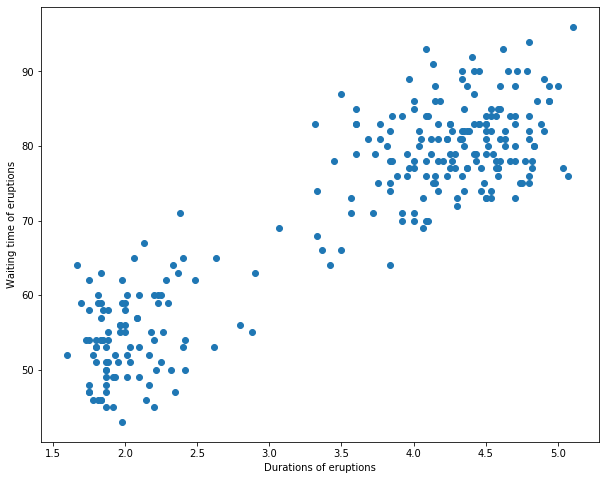

In [2]:
#import numpy as np
#import matplotlib.pyplot as plt 
#%matplotlib inline

#load the dataset
data = np.loadtxt('faithful.txt')
#print(data.shape)
#print(data)
#272 observations

#featured as 2d vectors
#Durations of eruptions = data[;,1]
x = data[:,1] 
#Waiting time of eruptions = data[;,2]
y = data[:,2]                                  

#plot waiting time between eruptions and durations of eruptions
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.scatter(x, y)
plt.xlabel("Durations of eruptions")
plt.ylabel("Waiting time of eruptions")
plt.show()

(c) Implement a bimodal GMMmodel to fit all data points using EMalgorithm. Explain the reasoning
behind your termination criteria. For this problem, we assume the covariance matrix
is spherical (i.e., it has the formof ¾2I for scalar ¾) and you can randomly initialize Gaussian
parameters. For evaluation purposes, please submit the following figures:
• Plot the trajectories of two mean vectors in 2 dimensions (i.e., coordinates vs. iteration).
• Run your program for 50 times with different initial parameter guesses. Show the distribution
of the total number of iterations needed for algorithmto converge.

Reason for termination:
For each (G) of the data points, set it to (G-Gmin)/(Gmax-Gmin).
Let the threshold to be as small as 1e-20, so when the difference of the log likelihood is smaller than the threshold, we will break.

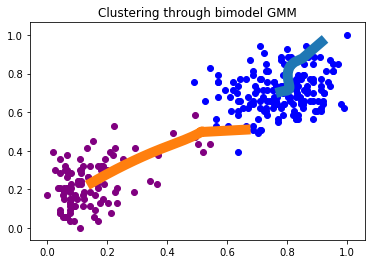

In [3]:
#import random,math
#from sklearn import preprocessing

#implement a biomodal GMMmodel
def GMM(G,M):             #M = 2
    NumofObservations, Dimension = np.shape(G)            
    N_of_O = 272                                                 #NumofObservations = 272
    D = 2                                                             #Dimension = 2
    idx_ = random.sample(range(N_of_O), D)            #Take random example             
    centriod = G[idx_] 
    vector_1 = []
    vector_1.append(centriod[0])
    vector_2 = []
    vector_2.append(centriod[1])

    [means,Pi,covs] = take_initial(G, centriod, M, NumofObservations, Dimension)              

    # Normalize so that the responsibility matrix is row stochastic
    while True:
        #calculate Gaussian posterior probability = gpp
        #import numpy as np
        gpp = GPP(means,covs,G,M,NumofObservations,Dimension)
        gamma = gpp * np.tile(Pi,(NumofObservations,1))
        gamma = gamma  / np.tile((np.sum(gamma,axis=1)),(M,1)).T  
        Num_k = np.sum(gamma,axis=0)
        means = np.dot(np.dot(np.diag(1 / Num_k),gamma.T), G)
        vector_1.append(means[0])
        vector_2.append(means[1])
        
        Pi = np.sum(gamma,axis=0) / NumofObservations
        #covariances
        for mp in range(M):
            new = G - np.tile(means[mp],(NumofObservations,1))
            covs[:,:,mp] = (np.dot(np.dot(new.T,np.diag(gamma[:,mp])),new)) / Num_k[mp]
        
        #set the log likelihood to be -infinite
        Logli = -np.inf   
        #termination/check for convergence
        L = np.sum(np.log(gpp*(Pi.T)))  
        if L-Logli < 1e-20:
            break        
        Logli = L
        
    return gpp, vector_1, vector_2

#define Gaussian posterior probability   
def GPP(means, covs, G, M, NumofObservations, Dimension):  
    gpp = np.zeros((NumofObservations, M))
    for m in range(M):
        new = G - np.tile(means[m],(NumofObservations,1))
        new_cov = np.linalg.pinv(covs[:,:,m]) 
        temp = np.sum(np.dot(new,new_cov) * new, axis = 1)
        coeficient = (2*np.pi)**(-Dimension/2) * np.sqrt(np.linalg.det(new_cov))
        gpp[:,m] = coeficient * np.exp(-0.5 * temp)
    return gpp

#define randomly initialize Gaussian parameters
def take_initial(G, centriod, M, NumofObservations, Dimension):
    means = centriod;
    Pi = np.zeros([1, M])
    #cov matrix of k components
    covs = np.zeros([Dimension, Dimension, M]) 
    dist = np.tile(np.sum(G * G, axis = 1),(M,1)).T + np.tile(np.sum(means * means,axis = 1).T,(NumofObservations,1)) - 2 * np.dot(G,means.T)
    row_index = np.argmin(dist,axis = 1)
    
    #covariances
    for m in range(M):
        xm = G[row_index==m]
        Pi[0][m] = float(np.shape(xm)[0]) / NumofObservations 
        covs[:,:,m] = np.cov(xm.T)
    
    return means,Pi,covs

#from sklearn import preprocessing
X = data[:,[1,2]] 
X = preprocessing.MinMaxScaler().fit_transform(X) 
gpp_1, vector_1, vector_2 = GMM(X,2)
index = np.argmax(gpp_1,axis=1) 
    
#plot the dataset
plt.scatter(X[index==0][:,0],X[index==0][:,1],c="blue")
plt.scatter(X[index==1][:,0],X[index==1][:,1],c="purple")
    
#plot the trajectories of two mean vectors in 2 dimensions
plt.plot(np.mat(vector_1)[:,0],np.mat(vector_1)[:,1],linewidth = 10)
plt.plot(np.mat(vector_2)[:,0],np.mat(vector_2)[:,1],linewidth = 10)
plt.title("Clustering through bimodel GMM") 
plt.show()


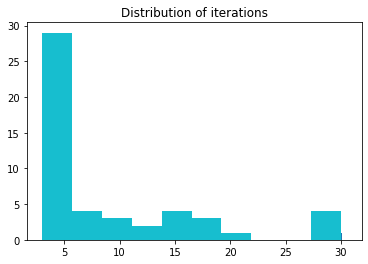

In [7]:
#Run for 50 times with different initial parameter guesses.
#Show the distribution of the total number of iterations needed for algorithmto converge
dist_it = []
for i in range(50):
    gpp_1, vector_1, vector_2 = GMM(X,2)
    dist_it.append(np.mat(vector_1).shape[0])
    plt.title("Distribution of iterations")
    plt.hist(dist_it)

(d) Repeat the task in (c) but with the initial guesses of the parameters generated from the following
process:
• Run a k-means algorithm over all the data points with K Æ 2 and label each point with
one of the two clusters.
• Estimate the first guess of the mean and covariance matrices using maximumlikelihood
over the labeled data points.
Compare the algorithm performances of (c) and (d).

Text(0.5, 1.0, 'Clustering through KMeans')

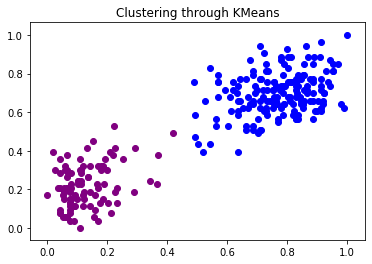

In [8]:
#Clustering through KMeans
#from sklearn.cluster import KMeans
#Run a k-means algorithm over all the data points with K Æ 2 and label each point with one of the two clusters
X = data[:,[1,2]]
X = preprocessing.MinMaxScaler().fit_transform(X) 
y_prediction = KMeans(n_clusters=2, random_state=150).fit_predict(X)
plt.scatter(X[y_prediction==0][:,0],X[y_prediction==0][:,1],c = 'blue')
plt.scatter(X[y_prediction==1][:,0],X[y_prediction==1][:,1],c = "purple")
plt.title("Clustering through KMeans")

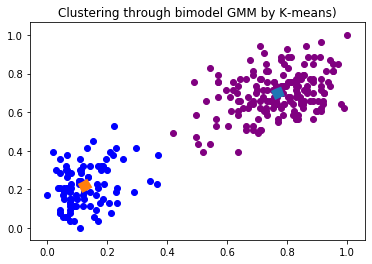

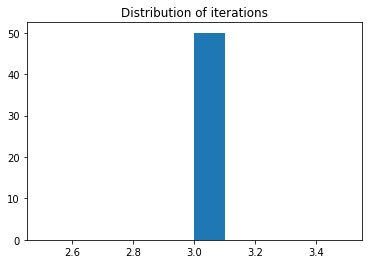

In [10]:
def kmeans(G,y_prediction,M,NumofObservations,Dimension):
    means = np.zeros([M, 2])
    Pi = np.zeros([1, M]) 
    covs = np.zeros([Dimension, Dimension, M])
    for m in range(M):
        Gm = G[y_prediction == m]     
        means[m,:] = np.mean(G[y_prediction == m],axis = 0)
        Pi[0][m] = float(np.shape(Gm)[0]) / NumofObservations 
        covs[:,:,m] = np.cov(Gm.T)
        
    return means,Pi,covs


#Repeat the task in (c) but with the initial guesses of the parameters
#Gaussian posterior probability   
def GPP(means,covs,G,M,NumofObservations,Dimension):
    gpp = np.zeros((NumofObservations,M))
    for m in range(M):
        new = G - np.tile(means[m],(NumofObservations,1))#X-means
        new_cov = np.linalg.pinv(covs[:,:,m]) 
        temp = np.sum(np.dot(new,new_cov) * new,axis=1)
        coeficient = (2*np.pi)**(-Dimension/2) * np.sqrt(np.linalg.det(new_cov))
        gpp[:,m] = coeficient * np.exp(-0.5 * temp)
    return gpp

#implement a biomodal GMMmodel by Kmeans
def GMM(G,M):
    NumofObservations, Dimension = np.shape(G)
    y_prediction = KMeans(n_clusters=M, random_state=150).fit_predict(G)  
    [means,Pi,covs] = kmeans(G,y_prediction,M,NumofObservations,Dimension)
      
    vector_1 = []
    vector_2 = []
    
    vector_1.append(means[0])
    vector_2.append(means[1])
    

    # Normalize so that the responsibility matrix is row stochastic
    while True:
        gpp = GPP(means,covs,G,M,NumofObservations,Dimension)
        gamma = gpp * np.tile(Pi,(NumofObservations,1))
        gamma = gamma / np.tile((np.sum(gamma,axis=1)),(M,1)).T
        Nm = np.sum(gamma,axis=0)
        means = np.dot(np.dot(np.diag(1 / Nm),gamma.T),G)
        vector_1.append(means[0])
        vector_2.append(means[1])
        Pi = Nm / NumofObservations
        for km in range(M):
            new = G - np.tile(means[km],(NumofObservations,1))
            covs[:,:,km] = (np.dot(np.dot(new.T,np.diag(gamma[:,km])),new)) / Nm[km]
        
        #set the log likelihood to be -infinite 
        Logli = -np.inf    
        L = np.sum(np.log(gpp*(Pi.T)))  
        if L-Logli < 1e-20:
            break        
        Logli = L
        
    return gpp, vector_1, vector_2



#from sklearn import preprocessing
X = data[:,[1,2]]
NumofObservations, Dimension = np.shape(X)
X = preprocessing.MinMaxScaler().fit_transform(X)
    
gpp_1, vector_1, vector_2 = GMM(X,2)
index = np.argmax(gpp_1,axis = 1)
plt.figure(1)
#plot the dataset
plt.scatter(X[index==0][:,0],X[index==0][:,1],c = 'blue')
plt.scatter(X[index==1][:,0],X[index==1][:,1],c = 'purple')   
plt.title("Clustering through bimodel GMM by K-means")
#plot the trajectories of two mean vectors in 2 dimensions
plt.plot(np.mat(vector_1)[:,0],np.mat(vector_1)[:,1],linewidth = 10)
plt.plot(np.mat(vector_2)[:,0],np.mat(vector_2)[:,1],linewidth = 10)   

#Run for 50 times with different initial parameter guesses.
#Show the distribution of the total number of iterations needed for algorithm to converge
dist_it = []   
    for i in range(50):
        gpp_1, vector_1, vector_2 = GMM(X,2)
        dist_it.append(np.mat(vector_1).shape[0])
    
    plt.figure(2)
    plt.title("Distribution of iterations")
    plt.hist(dist_it)

Compare the algorithm performances of (c) and (d):
Obviously, the distribution of iterations by kmeans is more nomarlized than that by randomly GMM. The GMM algorithms implemented by kmeans tends to be more stable and requires less iterations to reach its convergence.